# PRACTICING WITH DARTS

In this activity we are going to practice the concepts of Time Series and the **DARTS** library.

https://unit8co.github.io/darts/

You can work locally by installing in your computer the library. We also can need the **scipy** library for Fourier frequency analysis.

In [1]:
!pip install darts

## DATASETS with multiple series

Store Item Demand Forecasting (Kaggle)

https://www.kaggle.com/c/demand-forecasting-kernels-only

**Note**: This dataset has been synthetically generated through simulation. It would be relatively easy to find the functions used for generating them.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_demand = pd.read_csv('https://krono.act.uji.es/IDIA/demand-forecasting-train.csv', index_col=0, parse_dates=['date'])

In [4]:
df_demand.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [5]:
df_demand

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


We can organize the series by *item*, by *store* or to get the *total* sales for all products and stores.

For example, if we want to obtain the time series by product we pivot as follows:

`df_pivt = df_demand.pivot_table(index=['date'], columns='item', values='sales', aggfunc='sum')`

In this activity, we will deal with the *totals* time series (**the sum of all the items over all the stores at each time**).

In [6]:
## CODE HERE\
# Pivot the DataFrame by item
df_items = df_demand.pivot_table(
                            index='date',
                            columns='item',
                            values='sales',
                            aggfunc='sum'
                            )

# Calculate the 'totals' series (sum of all items over all stores at each time)
totals_series = df_items.sum(axis=1)
#totals_series.name = 'totals'

# Print the 'totals' series
print(totals_series)

date
2013-01-01    13696
2013-01-02    13678
2013-01-03    14488
2013-01-04    15677
2013-01-05    16237
              ...  
2017-12-27    20378
2017-12-28    21885
2017-12-29    23535
2017-12-30    24988
2017-12-31    26420
Length: 1826, dtype: int64


<Axes: xlabel='date'>

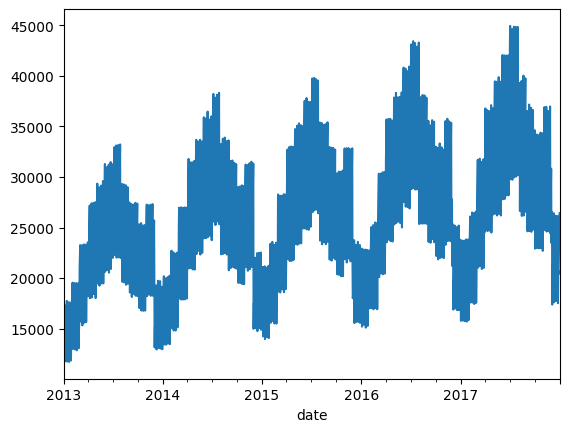

In [7]:
totals_series.plot()

## Decomposition of the time series
* Trend
* Cycles
* Seasons
* White noise

### TREND

Determine which is the trend of the time series. Is it stationary?

Trend (linear): [5.35209226e+00 2.12413593e+04] [6.06459705e+10]
Trend (quadratic): [-1.85429419e-03  8.73617916e+00  2.02125969e+04] [6.02581882e+10]


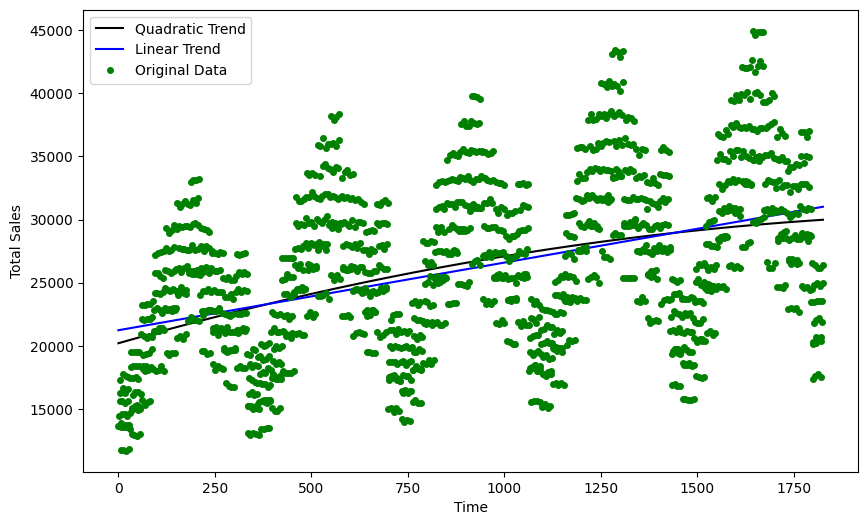

In [8]:
import matplotlib.pyplot as plt

# Assuming totals_series is your time series of interest
x = np.arange(len(totals_series))  # Assuming your index is numeric, otherwise, convert it to numeric

# Fit a linear trend
p1, res1, _, _, _ = np.polyfit(x, totals_series, 1, full=True)
p1_fn = np.poly1d(p1)

# Fit a quadratic trend
p2, res2, _, _, _ = np.polyfit(x, totals_series, 2, full=True)
p2_fn = np.poly1d(p2)

print("Trend (linear):", p1, res1)
print("Trend (quadratic):", p2, res2)

# Plot the trends and the original data
plt.figure(figsize=(10, 6))
plt.plot(x, p2_fn(x), 'k-', label='Quadratic Trend')
plt.plot(x, p1_fn(x), 'b-', label='Linear Trend')
plt.plot(x, totals_series, 'go', ms=4, label='Original Data')
plt.xlabel('Time')
plt.ylabel('Total Sales')
plt.legend()
plt.show()


In this code, x represents the time index (assuming your index is numeric), and polynomial regression is used to fit both linear and quadratic trends to the totals_series data. The np.polyfit function is utilized for polynomial regression. The trends and the original data are then plotted for visualization.

By observing the plot and the coefficients of the polynomial fits, you can assess the trend in your time series data. If the linear or quadratic trend lines show a clear pattern, the data might not be stationary. After looking at the time series graph, there appears to be a clear upward trend, therefore the series is probably not stationary.

### CYCLES

With the auto-correlation plot (AC), and Fourier analysis we aim to indentify the main cycles of the time series.

Auto-correlation: 0.7573895525156338


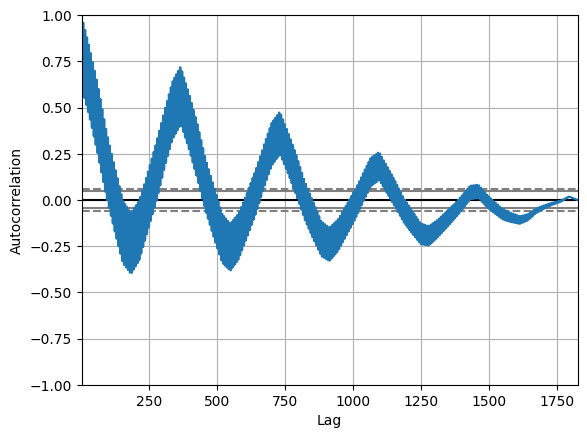

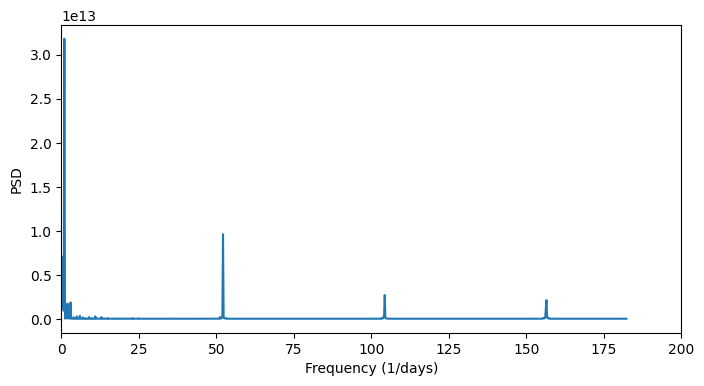

In [9]:
from pandas.plotting import autocorrelation_plot
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

# Calculate autocorrelation
print('Auto-correlation:', totals_series.autocorr())

# Autocorrelation plot
autocorrelation_plot(totals_series)

# Fourier analysis
temp_fft = sp.fftpack.fft(totals_series)
temp_psd = np.abs(temp_fft) ** 2

freq_unit = 1 / 365  # Frequency unit for daily data

fftfreq = sp.fftpack.fftfreq(len(temp_psd), freq_unit)

i = fftfreq > 0

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(fftfreq[i], temp_psd[i])
ax.set_xlim(0, 200)  # Adjust the x-axis limit based on your data
ax.set_xlabel('Frequency (1/days)')
ax.set_ylabel('PSD')

plt.show()


<Axes: xlabel='date'>

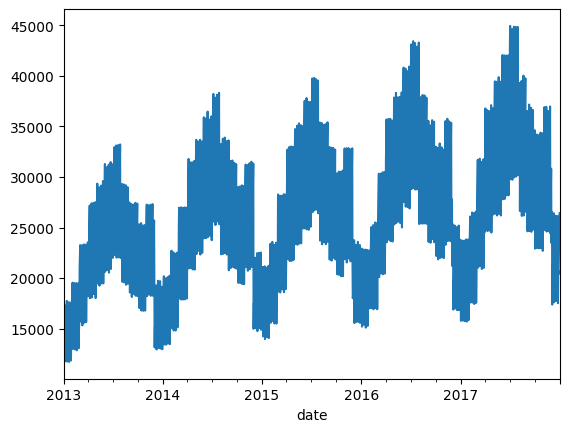

In [10]:
totals_series.plot()

<Axes: xlabel='date'>

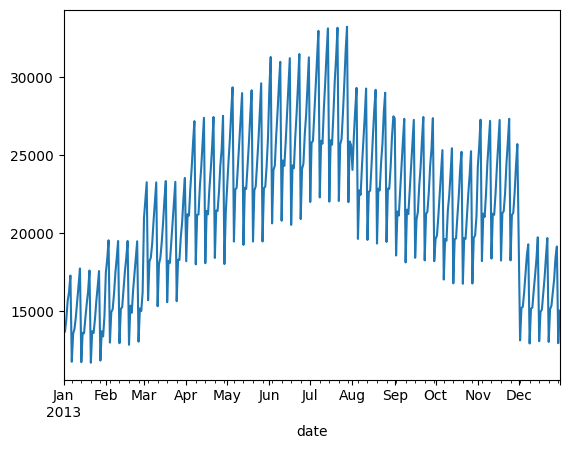

In [11]:
totals_series[0:365].plot()

<Axes: xlabel='date'>

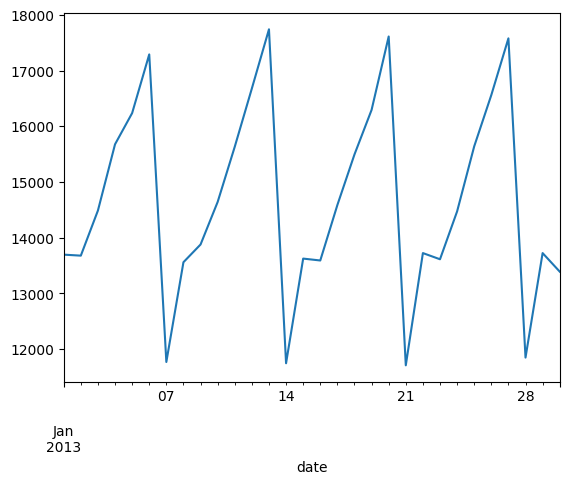

In [12]:
totals_series[0:30].plot()

<Axes: xlabel='date'>

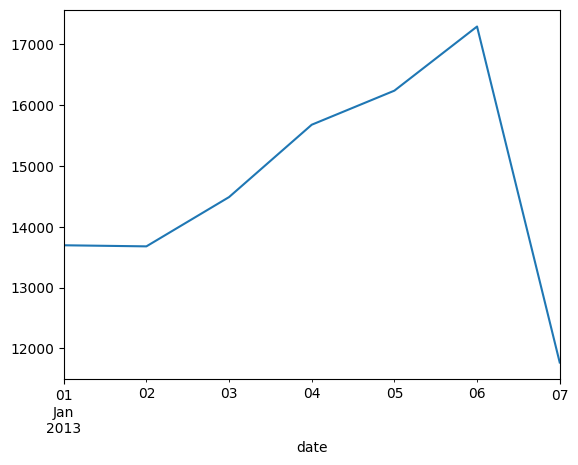

In [13]:
totals_series[0:7].plot()

As can be seen in the previous ACF and Fourier plots, there are 4 different cycles within the time series. If we expand the time series it can be seen that these cycles correspond to annual, monthly, weekly and daily cycles. These results indicate that sales follow a repetitive pattern every year, every month, every week and every day, which is due to strong seasonality, especially at an annual level in consumer behavior, seasonal events or climatic factors, among others. . possible causes.


### NORMALIZATION

Check different methods for **normalization** and choose the best for performing a forecast.

### Method 1: Log of the time series minus rolling mean

Goal: de-trend (by substracting the rolling mean) and eliminate the "multiplicative" effect of the original series (by applying log).

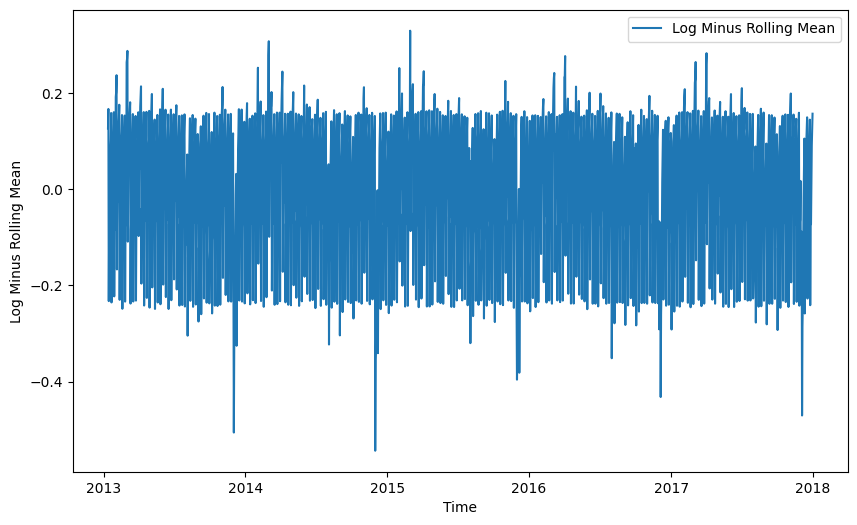

In [14]:
# Calculate log of the series
totals_log = np.log(totals_series)

# Calculate rolling mean
rolling_mean = totals_log.rolling(window=12).mean()

# Subtract rolling mean from the log series
totals_log_minus_mean = totals_log - rolling_mean

# Remove NaN values
totals_log_minus_mean.dropna(inplace=True)

# Plot the resulting stationary time series
plt.figure(figsize=(10, 6))
plt.plot(totals_log_minus_mean, label='Log Minus Rolling Mean')
plt.xlabel('Time')
plt.ylabel('Log Minus Rolling Mean')
plt.legend()
plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

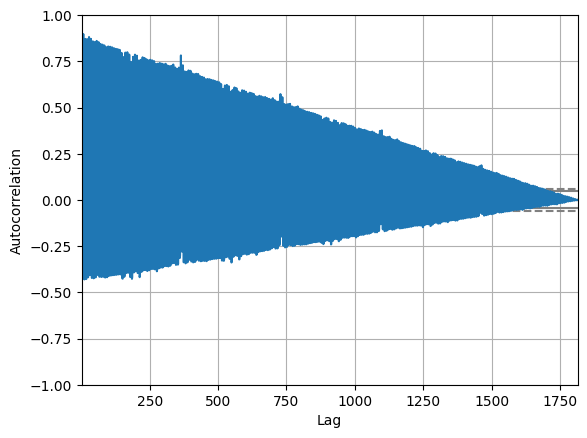

In [15]:
autocorrelation_plot(totals_log_minus_mean)

### Method 2. Exponential smoothing

Goal: like Method 1 but the moving average is calculated with exponential decay.

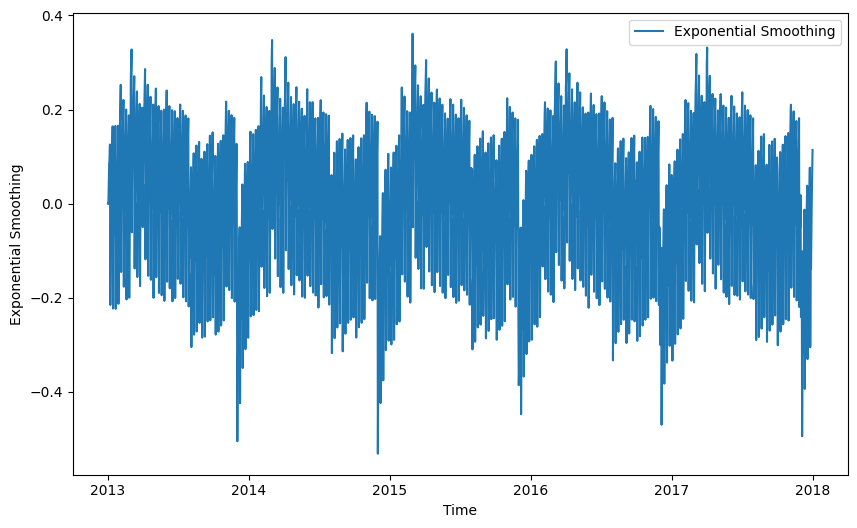

In [16]:
# Calculate log of the series
totals_log = np.log(totals_series)

# Calculate exponential smoothing (weighted moving average)
rolling_mean_exp_decay = totals_log.ewm(halflife=12, min_periods=0, adjust=True).mean()

# Subtract exponential smoothing from the log series
totals_log_exp_decay = totals_log - rolling_mean_exp_decay

# Remove NaN values
totals_log_exp_decay.dropna(inplace=True)

# Plot the resulting stationary time series
plt.figure(figsize=(10, 6))
plt.plot(totals_log_exp_decay, label='Exponential Smoothing')
plt.xlabel('Time')
plt.ylabel('Exponential Smoothing')
plt.legend()
plt.show()


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

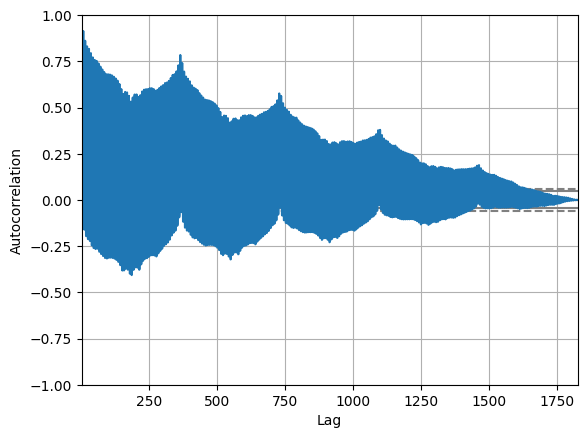

In [17]:
autocorrelation_plot(totals_log_exp_decay)

### Method 3: Differentiation

Goal: apply the differenation of the series to reduce the seasonability effect.

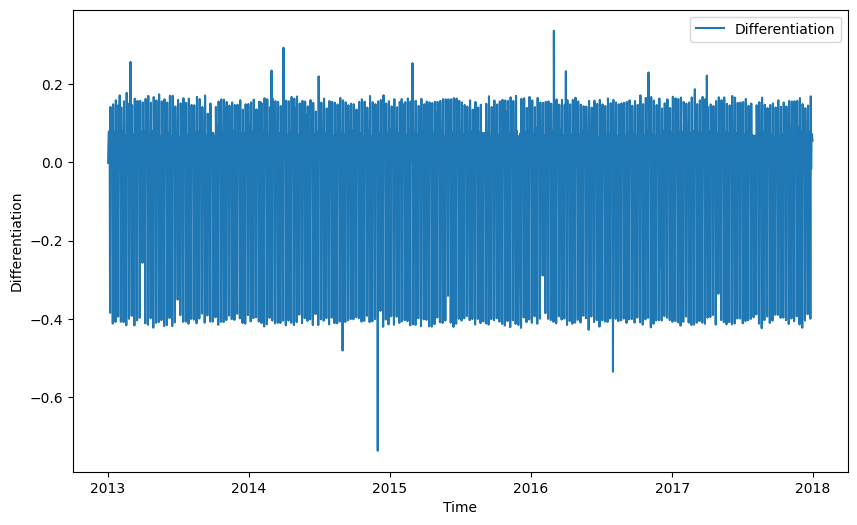

In [18]:
# Calculate log of the series
totals_log = np.log(totals_series)

# Perform differentiation (first-order difference)
totals_log_diff = totals_log.diff()
totals_log_diff.dropna(inplace=True)

# Plot the resulting stationary time series after differentiation
plt.figure(figsize=(10, 6))
plt.plot(totals_log_diff, label='Differentiation')
plt.xlabel('Time')
plt.ylabel('Differentiation')
plt.legend()
plt.show()


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

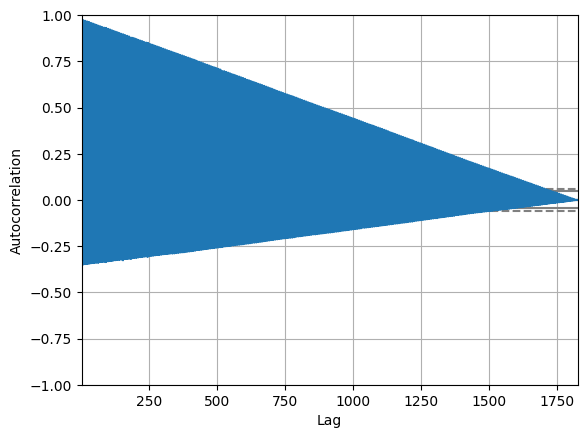

In [19]:
autocorrelation_plot(totals_log_diff)

After viewing the original data and the normalized series using each method, the method that best stabilizes the variance and eliminates trends and seasonality has been chosen, making the data appear more stationary, in this case the first method.


## TIME SERIES FORECAST

Train **two forecasting models** for predicting the time series, one classical and another based on neural networks. Evaluate their quality with MAPE/RMSE metric.

You can use any of the models provided by DARTS:

https://unit8co.github.io/darts/#forecasting-models


MAPE =  6.404853667797426
RMSE =  2229.3878322215023


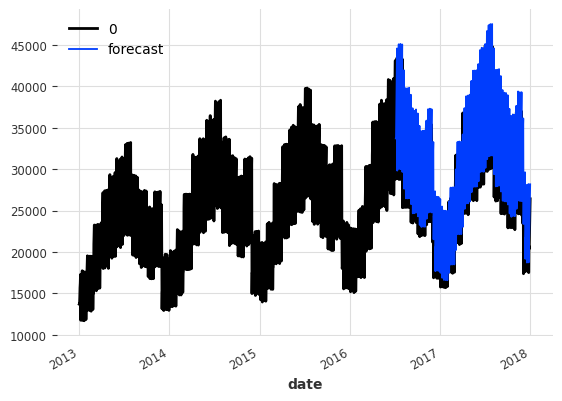

In [20]:
## CODE HERE
from darts import TimeSeries
from darts.models import ExponentialSmoothing
from darts.metrics import mape, rmse
from darts.utils.timeseries_generation import gaussian_timeseries

series = totals_series
cut = -545

# Create a TimeSeries from the normalized series
normalized_series = TimeSeries.from_series(totals_log_minus_mean)
series = TimeSeries.from_series(series)
rolling = TimeSeries.from_series(rolling_mean[cut:])

# Split the series into train and validation sets
train, val = normalized_series[:cut], normalized_series[cut:]

# Build and train the model
model = ExponentialSmoothing()
model.fit(train)

# Forecast the validation period
prediction_normalized = model.predict(len(val))

# inverse
pred_inv = prediction_normalized + rolling
# Transform the prediction back to the original scale
prediction = np.exp(pred_inv.pd_series())

# Visualize the prediction
series.plot()
prediction.plot(label='forecast')
plt.legend()

# Calculate and print MAPE and RMSE
prediction = TimeSeries.from_series(prediction)
val = series[cut:]
mape_score = mape(val, prediction)
rmse_score = rmse(val, prediction)

print('MAPE = ', mape_score)
print('RMSE = ', rmse_score)



[introduce explanation of *results* here]

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe87baqs4/gv3ytpdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe87baqs4/xe0wbdkh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34442', 'data', 'file=/tmp/tmpe87baqs4/gv3ytpdq.json', 'init=/tmp/tmpe87baqs4/xe0wbdkh.json', 'output', 'file=/tmp/tmpe87baqs4/prophet_model42nya3n_/prophet_model-20231019150809.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:08:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:08:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE =  2.6451270559641826
RMSE =  1057.1509406447296


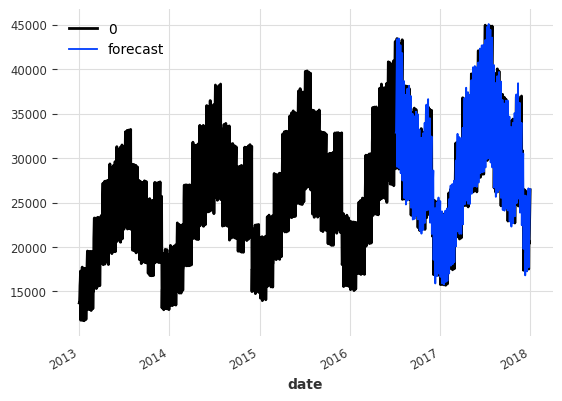

In [21]:
from darts.models import Prophet

# Build and train the Prophet model
model2 = Prophet()
model2.fit(train)

# Forecast the validation period
prediction_normalized = model2.predict(len(val))

# inverse
pred_inv = prediction_normalized + rolling
# Transform the prediction back to the original scale
prediction = np.exp(pred_inv.pd_series())

# Visualize the prediction
series.plot()
prediction.plot(label='forecast')
plt.legend()

# Calculate and print MAPE and RMSE
prediction = TimeSeries.from_series(prediction)
val = series[cut:]
mape_score = mape(val, prediction)
rmse_score = rmse(val, prediction)

print('MAPE = ', mape_score)
print('RMSE = ', rmse_score)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.6 M 
---------------------------------------------------
1.6 M     Trainable params
3.1 K     Non-trainable params
1.6 M     Total params
6.488     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE =  3.139087327104299
RMSE =  1450.597498319187


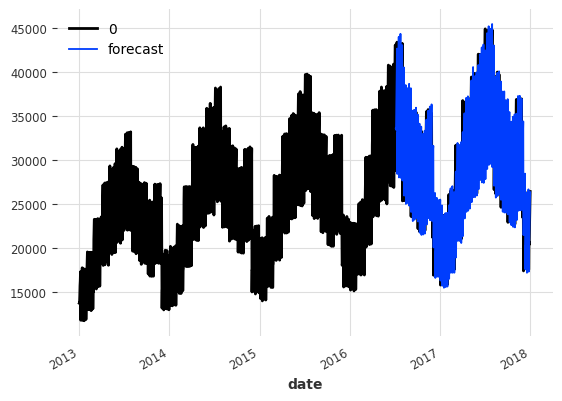

In [22]:
from darts.models import NHiTSModel

# Build and train the Prophet model
model3 = NHiTSModel(
    input_chunk_length=6,
    output_chunk_length=6,
    num_blocks=2,
    n_epochs=10,
)
model3.fit(train)

# Forecast the validation period
prediction_normalized = model3.predict(len(val))

# inverse
pred_inv = prediction_normalized + rolling
# Transform the prediction back to the original scale
prediction = np.exp(pred_inv.pd_series())

# Visualize the prediction
series.plot()
prediction.plot(label='forecast')
plt.legend()

# Calculate and print MAPE and RMSE
prediction = TimeSeries.from_series(prediction)
val = series[cut:]
mape_score = mape(val, prediction)
rmse_score = rmse(val, prediction)

print('MAPE = ', mape_score)
print('RMSE = ', rmse_score)


As can be seen both in the plots and in the evaluation metrics, the best model is the one based on neural networks and the prophet.